<center><font color='#0C2577'><b>Advances in Deep Learning</b></font></center>

<center><sup>ArtEmis NLP Module</sup></center>

<center><img src="https://i.imgur.com/BC2sAdw.png" alt="Alt text that describes the graphic" title="Universiteit Leiden"/></center>

<center><font color='#0C2577'><b>Leiden University</b></font></center>

<center><sub>To work on this interactive practical in Google Colab, click File and then Save a copy in Drive.</sub></center>



## Initialization

GitHub Token

In [ ]:
token = input("Input GitHub API Token: ")

### Installation

In [ ]:
from IPython.display import clear_output
!pip install watermark
!pip install -qq transformers
%load_ext watermark
clear_output(wait=True)
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 4.5.1



### Data Retrieval

Clone Repository

In [ ]:
repository = "https://" + token + "@github.com/sendeniz/affective-creative-adverserial-net.git"
!git clone $repository artemis

Cloning into 'artemis'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 348 (delta 31), reused 0 (delta 0), pack-reused 288
Receiving objects: 100% (348/348), 180.97 MiB | 31.81 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Checking out files: 100% (153/153), done.


Install Python Modules

In [ ]:
%cd artemis
!pip install -e .
clear_output(wait=True)

Pre-Process Data

In [ ]:
!python artemis/scripts/preprocess_artemis_data.py -save-out-dir data -raw-artemis-data-csv official_data/artemis_dataset_release_v0.csv
clear_output(wait=True)

{'automatic_spell_check': True,
 'group_gt_anno': True,
 'min_word_freq': 0,
 'n_train_examples': None,
 'preprocess_for_deep_nets': False,
 'random_seed': 2021,
 'raw_artemis_data_csv': 'official_data/artemis_dataset_release_v0.csv',
 'save_out_dir': 'data',
 'split_loads': [0.85, 0.05, 0.1],
 'too_high_repetition': -1,
 'too_long_utter_prc': 100,
 'too_short_len': 0}
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
454684 annotations were loaded
Using a 0.85,0.05,0.1 for train/val/test purposes
SymSpell spell-checker loaded: True
Loading glove word embeddings.
Done. 400000 words loaded.
Updating Glove vocabulary with *valid* ArtEmis words that are missing from it.
0 annotations will be dropped as they contain less than 0 tokens
Too-long token length at 100-percentile is 207.0. 0 annotations will be dropped
Using a vocabulary with 35469 tokens
n-utterances kept: 454684
vocab size: 35469
tokens not in Glove/Manual vocabulary: 662

### Libraries

In [ ]:
# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

# Vector Compute
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Transformer Model
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

# Helper Functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Misc Libraries
from pylab import rcParams
from collections import defaultdict
from textwrap import wrap

# Utilities
from tqdm.notebook import tqdm

### Configuration

In [ ]:
sns.set_style("whitegrid", {
    "ytick.major.size": 0.1,
    "ytick.minor.size": 0.05,
    'grid.linestyle': '--'
 })

In [ ]:
RANDOM_SEED = 2021
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data Processing

In [ ]:
emotion_labels = {0 : "amusement", 1 : "awe", 2 : "contentment", 3 : "excitement", 
                  4 : "anger", 5 : "disgust", 6 : "fear", 7 : "sadness",
                  8 : "something else"}

In [ ]:
data = pd.read_csv('data/artemis_preprocessed.csv')
df = pd.DataFrame()
df[['data', 'label']] = data[['utterance', 'emotion_label']]
pd.DataFrame({"Count":df.label.value_counts(),
              "Fraction":round(df.label.value_counts()/df.label.count(),4)}) \
              .rename(index=emotion_labels)

,Count,Fraction
contentment,126134,0.2774
awe,72927,0.1604
something else,52962,0.1165
sadness,49061,0.1079
amusement,45336,0.0997
fear,41577,0.0914
excitement,37636,0.0828
disgust,22411,0.0493
anger,6640,0.0146


,count,mean,std,min,25%,50%,75%,max
0,454684.0,20.467731,9.681872,3.0,14.0,18.0,24.0,254.0


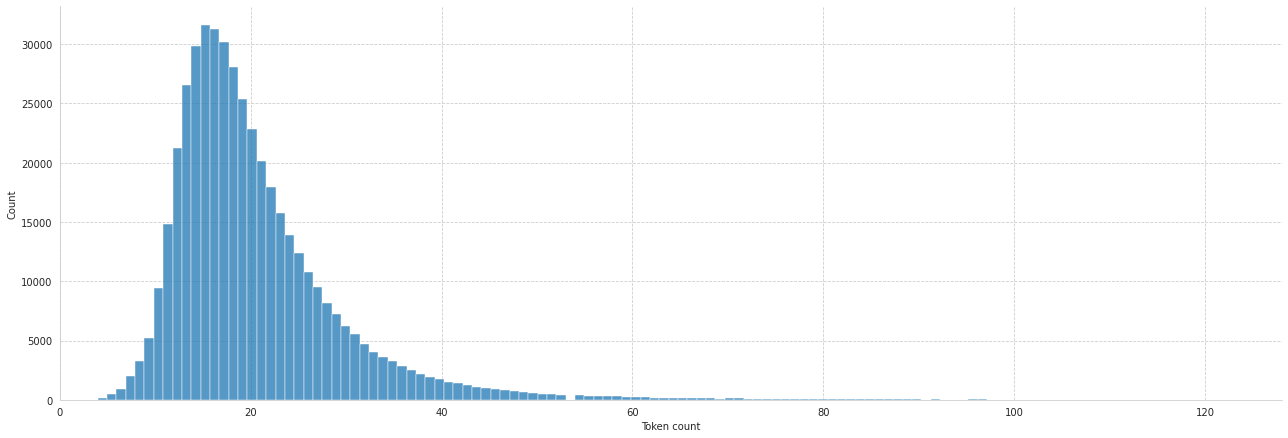

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
clear_output(wait=True)

token_lens = []
for txt in tqdm(df.data):
  tokens = tokenizer.encode(txt, truncation=True, max_length=512)
  token_lens.append(len(tokens))

sns.displot(token_lens, bins = 256, height=6, aspect=3.0)
plt.xlim([0, 128]);
plt.xlabel('Token count');
pd.DataFrame(token_lens).describe().T

## Data Loader

### Configuration

In [ ]:
MAX_LEN = 64
BATCH_SIZE = 16

### Loader

In [ ]:
class encoder(Dataset):

  def __init__(self, data, labels, tokenizer, max_len):

    self.data = data
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):

    return len(self.data)

  def __getitem__(self, item):

    datum = str(self.data[item])
    label = self.labels[item]
    
    encoding = self.tokenizer.encode_plus(
      datum,
      padding='max_length',
      truncation=True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'feat_text': datum,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(label, dtype=torch.long)
    }

def create_data_loader(df, tokenizer, max_len, batch_size):

  feature_encoder = encoder(
    data=df.data.to_numpy(),
    labels=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

  return DataLoader(
    feature_encoder,
    batch_size=batch_size,
    num_workers=2)

### Data Split

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
train_data_loader.dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'feat_text': "I can tell that this should be a person but I can't tell where their head is which I find strangely funny.",
 'input_ids': tensor([  101,   146,  1169,  1587,  1115,  1142,  1431,  1129,   170,  1825,
          1133,   146,  1169,   112,   189,  1587,  1187,  1147,  1246,  1110,
          1134,   146,  1525, 16352,  6276,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'targets': tensor(0)}

## Model

### Torch Module Specification

In [ ]:
class BertClassifier(nn.Module):

  def __init__(self, n):

    super(BertClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n)

  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)

    return self.out(output)

In [ ]:
model = BertClassifier(len(emotion_labels))
model = model.to(device)

##  Training

### Configuration

In [ ]:
EPOCHS = 5

### Optimizer

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

### Training Schedule

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples):

  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask)
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

### Evaluation

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask)
      
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
      
  return correct_predictions.double() / n_examples, np.mean(losses)

### Main Loop

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train))
  
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

### Training Diagnostics

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

### Classify Test Set

In [ ]:
def get_predictions(model, data_loader):

  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["feat_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask)

      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

### Classification Report

In [ ]:
y_feat_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=list(emotion_labels.values())))

In [ ]:
def show_confusion_matrix(confusion_matrix):

  fig, ax = plt.subplots(figsize=(10,10))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax)
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted Sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=list(emotion_labels.values()), columns=list(emotion_labels.values()))
show_confusion_matrix(df_cm)

### Input Example

In [ ]:
feat_text = "The scene fills me with melancholy, yet I am not sure why."

In [ ]:
encoded_review = tokenizer.encode_plus(
  feat_text,
  padding='max_length',
  truncation=True,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Feature  : {feat_text}')
print(f'Sentiment: {list(emotion_labels.values())[prediction]}')